In [1]:
import transformers
import pandas as pd
import os, re

os.getcwd()

/home/barti/miniconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'/home/barti/PosterRecognition/vit'

In [2]:
data = pd.read_csv("../scraper/data/movies_with_posters_and_rich_desc.csv")

In [3]:
data['imdb_id'] = data['imdb_id'].apply(lambda x: re.sub(r"^t+0*", "", x))
data['imdb_id']

0         57603
1       1733125
2         33045
3        113862
4         86250
         ...   
9766    1869716
9767      25601
9768     102592
9769      63443
9770      39464
Name: imdb_id, Length: 9771, dtype: object

In [4]:
import shutil

data = data.loc[data['poster_count'] > 3]

posters = os.listdir("../scraper/data/images")
valid_num_posters = set(data['imdb_id'].values)

for poster in posters:
    if poster not in valid_num_posters:
        shutil.rmtree("../scraper/data/images/" + poster)

len(os.listdir("../scraper/data/images")), len(data)

(4709, 4709)

In [6]:
from transformers import ViTModel

vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

In [7]:
from transformers import AutoImageProcessor
from torchvision import transforms
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import torch

processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

torch.Size([3, 224, 224])

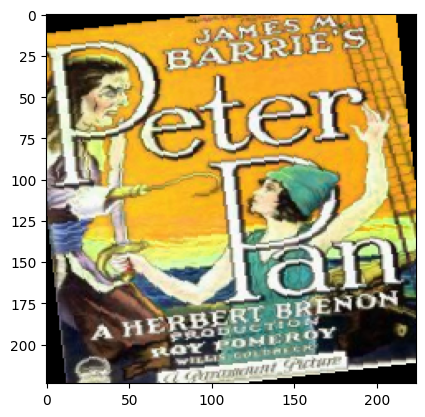

In [25]:
im = Image.open("/home/barti/PosterRecognition/scraper/data/images/15224/train/s_15224_3a23e5f7.jpg")

imtransformer = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.1,
                           contrast=0.1,
                           saturation=0.1,
                           hue=0.1),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor()
])
# scripted_transforms = torch.jit.script(imtransformer)
# # imtransformer(im).permute(1, 2, 0)
plt.imshow(imtransformer(im).permute(1, 2, 0))

image_tensor = imtransformer(im)
image_tensor.shape

In [10]:
res = processor(image_tensor.permute(1, 2, 0), return_tensors='pt')['pixel_values']
res.shape

torch.Size([1, 3, 224, 224])

In [11]:
id_mapping = {movie_id: title for movie_id, title in zip(data['imdb_id'].values, data['title'].values)}

assert id_mapping['15224'] == "Peter Pan"

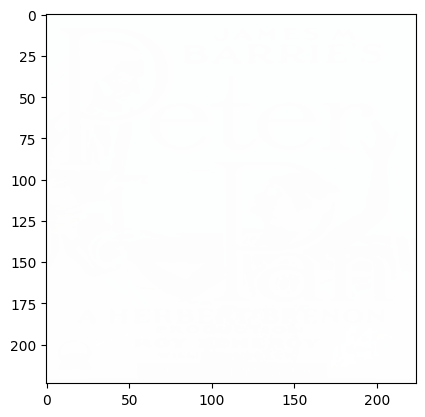

In [12]:
plt.imshow((-1*res[0]).permute(1, 2, 0))

In [13]:
data.groupby(['poster_count']).count()

imdb_id  plot_synopsis  tags  adult  belongs_to_collection   
poster_count                                                               
4.0               935            935   935    935                    162  \
5.0               677            677   677    677                    125   
6.0              2568           2568  2568   2568                    670   
7.0               111            111   111    111                     24   
8.0               128            128   128    128                     31   
9.0                97             97    97     97                     27   
10.0               89             89    89     89                     36   
11.0               68             68    68     68                     37   
12.0               29             29    29     29                     13   
13.0                1              1     1      1                      1   
14.0                3              3     3      3                      3   
16.0                2              2     2      2                      2   
17.0                1              1     1      1                      0   

              budget  genres  homepage    id  original_language  ...  revenue   
poster_count                                                     ...            
4.0              935     935       170   935                935  ...      935  \
5.0              677     677       137   677                677  ...      677   
6.0             2568    2568       771  2568               2568  ...     2568   
7.0              111     111        41   111                111  ...      111   
8.0              128     128        56   128                128  ...      128   
9.0               97      97        51    97                 97  ...       97   
10.0              89      89        42    89                 89  ...       89   
11.0              68      68        38    68                 68  ...       68   
12.0              29      29         9    29                 29  ...       29   
13.0               1       1         0     1                  1  ...        1   
14.0               3       3         2     3                  3  ...        3   
16.0               2       2         0     2                  2  ...        2   
17.0               1       1         1     1                  1  ...        1   

              runtime  spoken_languages  status  tagline  video  vote_average   
poster_count                                                                    
4.0               935               935     935      730    935           935  \
5.0               677               677     677      538    677           677   
6.0              2568              2568    2568     2104   2568          2568   
7.0               111               111     111       95    111           111   
8.0               128               128     128      101    128           128   
9.0                97                97      97       85     97            97   
10.0               89                89      89       82     89            89   
11.0               68                68      68       63     68            68   
12.0               29                29      29       28     29            29   
13.0                1                 1       1        1      1             1   
14.0                3                 3       3        3      3             3   
16.0                2                 2       2        2      2             2   
17.0                1                 1       1        1      1             1   

              vote_count  num_description_tokens  title  
poster_count                                             
4.0                  935                     935    935  
5.0                  677                     677    677  
6.0                 2568                    2568   2568  
7.0                  111                     111    111  
8.0                  128                     128    128  
9.0                   97           

In [27]:
from torchvision.datasets import ImageFolder

train_dataset = ImageFolder("../scraper/data/images", transform=imtransformer)

imdb_id                                      plot_synopsis   
4189  100029  A man is buying drugs from a dealer until his ...  \

                                                   tags  adult   
4189  comedy, neo noir, murder, violence, cult, humo...  False  \

     belongs_to_collection   budget   
4189                   NaN  6000000  \

                                                 genres homepage    id   
4189  [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...      NaN  9399  \

     original_language  ... runtime                          spoken_languages   
4189                en  ...   105.0  [{'iso_639_1': 'en', 'name': 'English'}]  \

        status                                            tagline  video   
4189  Released  When the streets are a jungle... There can onl...  False  \

     vote_average vote_count  poster_count  num_description_tokens      title  
4189          5.9      179.0           4.0                     581  Lionheart  

[1 rows x 28 columns]

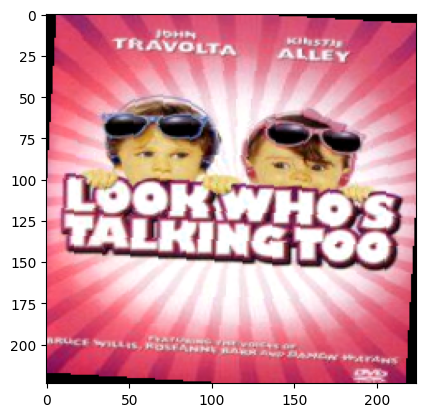

In [28]:
train_dataset[4][0].shape
cls = train_dataset[0][1]


plt.imshow(train_dataset[4][0].permute(1, 2, 0))

data.loc[data['imdb_id']==train_dataset.classes[0]]

In [35]:
from data_manipulation import PosterDataset

train_dataset = PosterDataset("../scraper/data/images", transform=imtransformer)

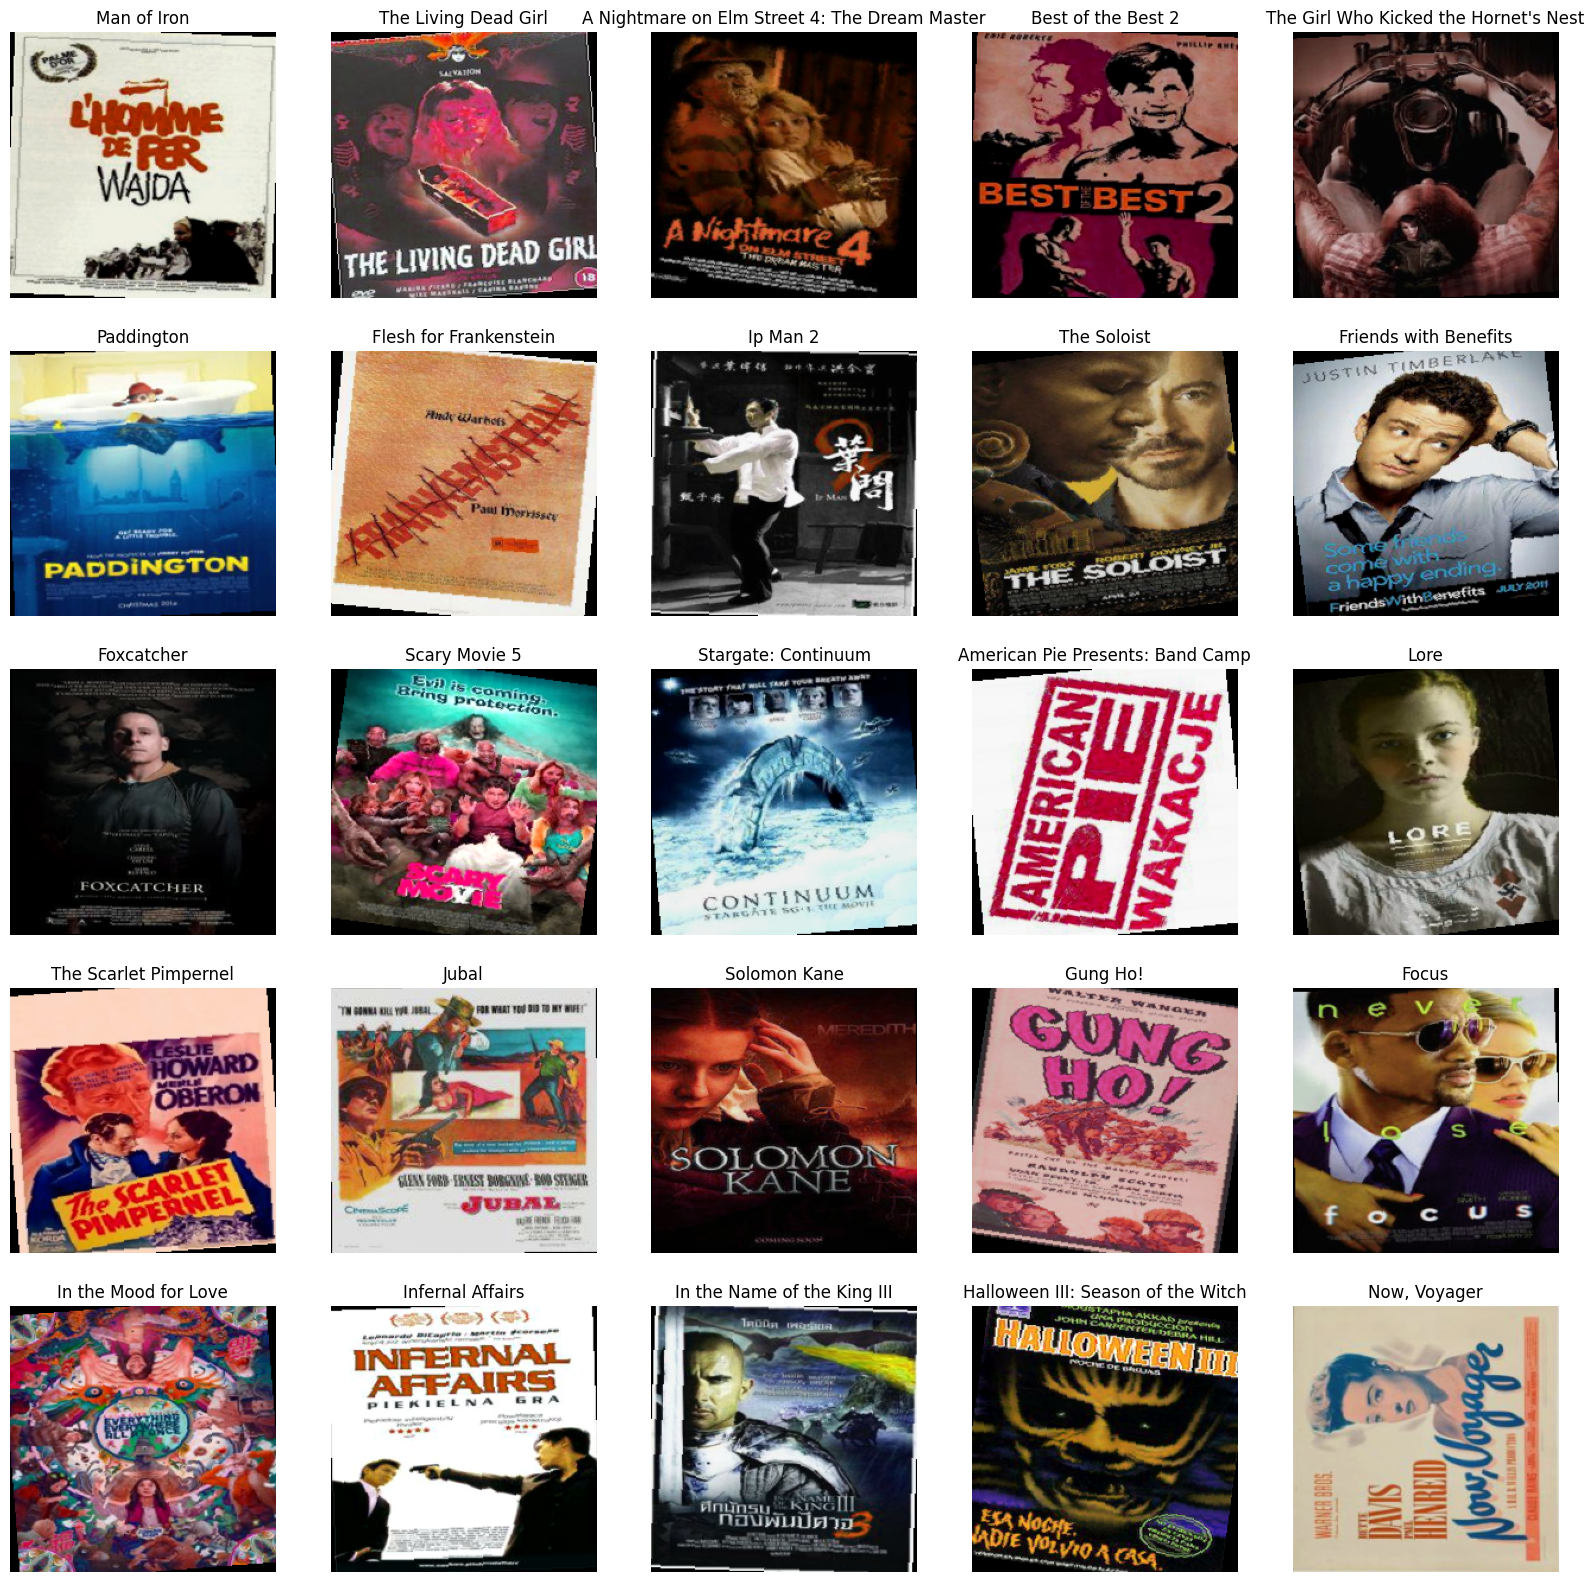

In [39]:
plt.figure(figsize=(20, 20))
for i, idx in enumerate(random.randint(0, len(train_dataset)) for _ in range(25)):
    image, clsIdx = train_dataset[idx]
    ax = plt.subplot(5, 5, i+1)
    plt.title(f"{id_mapping[train_dataset.idxToClassName(clsIdx.item())]}")
    plt.axis('off')
    plt.imshow(image.permute(1, 2, 0))


In [34]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=8,
                                           shuffle=True,
                                           num_workers=4,
                                           pin_memory=True)
num_cls = train_dataset.getNumClasses()
for i, (X, cls) in enumerate(train_loader):
    Y = torch.nn.functional.one_hot(cls, num_classes=num_cls)
    X = processor(X, return_tensors='pt')['pixel_values']
    print(X.shape, Y.shape)
    res = vit.forward(X,
                      return_dict=False,
                      output_attentions=False,
                      output_hidden_states=False)[0]
    print(res[0].shape, res[1].shape)
    # print(X.shape, Y.shape)
    break

torch.Size([8, 3, 224, 224]) torch.Size([8, 4709])
torch.Size([8, 197, 768]) torch.Size([8, 768])
